# imports

In [ ]:
import re
import unicodedata
import gdown
import zipfile
import os
from datetime import datetime, timedelta
import time
import pandas as pd
from transformers import pipeline
from tokenizers.decoders import WordPiece
from collections import defaultdict

# Data Processing

## loading

In [ ]:

def extract_data(drive_id, file_name):
  destination = "Data/"
  gdown.download(f"https://drive.google.com/uc?id={drive_id}", destination, quiet=False)

  zip_path = f"Data/{file_name}.zip"  # Replace with the path to your ZIP file

  # Extract the ZIP file
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
      zip_ref.extractall(destination)

  if os.path.exists(zip_path):
    os.remove(zip_path)

  # extracted_files = os.listdir(destination)
  # for curr_file_name in extracted_files:
  #       file_path = os.path.join(destination, curr_file_name)
  #       new_file_path = os.path.join(destination, file_name)
  #       os.rename(file_path, new_file_path)

extract_data("1OpYoVnxeP6gdjnLv-n1xWVBGMTeu2ViC", 'project_chat')

Downloading...
From: https://drive.google.com/uc?id=1OpYoVnxeP6gdjnLv-n1xWVBGMTeu2ViC
To: /content/Data/project_chat.zip
100%|██████████| 19.5k/19.5k [00:00<00:00, 22.6MB/s]


In [ ]:
with open('Data/project_chat.txt', 'r', encoding='utf-8') as file:
    content = file.readlines()  # Reads all lines into a list

## Data processing

In [ ]:
class data_processing:
  def __init__(self):
    self.df = None

  def clean_hebrew_text(self, text):
    # Normalize the text to NFC form (decompose characters and remove any unwanted combining marks)
    text = unicodedata.normalize('NFC', text)

    # Remove emojis and other non-Hebrew characters using a regular expression
    # This regex matches any characters that are not Hebrew letters or spaces
    cleaned_text = re.sub(r'[\U00010000-\U0010FFFF]+', '', text)
    cleaned_text = re.sub(r'\u200f', '', cleaned_text)
    cleaned_text = re.sub(r'<המדיה לא נכללה>', '', cleaned_text)
    cleaned_text = re.sub(r'<ההודעה נערכה>', '', cleaned_text)
    cleaned_text = re.sub(r'הודעה זו נמחקה', '', cleaned_text)

    return cleaned_text

  def load_chat(self, file_path):
          """
          Load and parse a WhatsApp chat export file

          Args:
              file_path: Path to the WhatsApp chat export file

          Returns:
              DataFrame containing parsed messages
          """
          print("Loading chat file...")
          start_time = time.time()

          try:
              with open(file_path, 'r', encoding='utf-8') as file:
                  content = file.read()
          except Exception as e:
              print(f"Error loading file: {str(e)}")
              return pd.DataFrame()

          # WhatsApp message pattern
          pattern = r'(\d{1,2}\.\d{1,2}\.\d{4}),\s(\d{1,2}:\d{2})\s-\s([^:]+):\s(.+)'

          messages = []
          for line in content.split('\n'):
              match = re.match(pattern, line)
              if match:
                  date, time_str, sender, content = match.groups()
                  messages.append({
                      'date': date,
                      'time': time_str,
                      'sender': sender.strip(),
                      'content': self.clean_hebrew_text(content.strip())
                  })

          df = pd.DataFrame(messages)
          df = df[df['content'].str.strip().astype(bool)]
          df['content'] = df['content'].astype(str)
          df['content_len'] = df['content'].str.len()
          df["id"] = range(1, len(df) + 1)
          load_time = time.time() - start_time


          print(f"Loading completed in {load_time:.2f} seconds")
          print(f"Loaded {len(df)} messages")

          self.df = df

  def add_message_id(self, time_gap=1):

    self.df['datetime'] = pd.to_datetime(self.df['date'] + ' ' + self.df['time'], format='%d.%m.%Y %H:%M')
    message_number = 1
    previous_datetime = None

    # Create a new column for message numbers
    self.df['message_id'] = 0
    seconds = int(time_gap * 3600)

    for idx, row in self.df.iterrows():
      curr_datetime = row['datetime']

      # Check if the current message falls within the cutoff window
      if previous_datetime is not None and (
          (curr_datetime - previous_datetime).total_seconds() < seconds
      ):
          self.df.at[idx, 'message_id'] = message_number
      else:
          # Increment message group
          message_number += 1

          self.df.at[idx, 'message_id'] = message_number

      # Update the previous datetime for the next iteration
      previous_datetime = curr_datetime

    self.df['message_id'] = self.df['message_id'].astype(int)
    self.df = self.df.drop(columns=['datetime'])



  def get_df(self):
    return self.df

In [ ]:
import re
import unicodedata
from transformers import pipeline
from tokenizers.decoders import WordPiece
from collections import defaultdict

class anonymizer():
    """
    This class handles anonymization by:
      1) Using a Hebrew NER model (dicta-il/dictabert-ner or dicta-il/dictabert-large-ner).
      2) Using regex patterns to identify phone numbers, IDs, emails, credit cards, websites.
      3) Splitting overly-long text segments (based on max_chars) to avoid offset issues.
      4) Censoring the identified entities with asterisks.
    """

    def __init__(self):
        self.anonymize = pipeline('ner', model='dicta-il/dictabert-large-ner', aggregation_strategy='simple')
        self.anonymize.tokenizer.backend_tokenizer.decoder = WordPiece()

    def regex_anonymizer(self, text):

        patterns = {
            'phone': {
                'pattern': r'972[-\s]?0?(?:[23489]|5[0-9])[-\s]?\d{7}@?\b',
                'replacement': 'PHONE_NUMBER'
            },
            'id': {
                'pattern': r'\b\d{9}\b',
                'replacement': 'ID_NUMBER'
            },
            'email': {
                'pattern': r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',
                'replacement': 'EMAIL'
            },
            'credit_card': {
                'pattern': r'\b(?:\d{4}[-\s]?){3}\d{4}\b',
                'replacement': 'CREDIT_CARD'
            },
                # Enhanced pattern that captures everything up to the next whitespace
            'website': {
                'pattern': r'(?:https?://\S+|www\.\S+)',
                'replacement': 'WEBSITE'
            }
        }

        regex_results = []

        for key, value in patterns.items():
            pattern = value['pattern']

            for match in re.finditer(pattern, text):
                curr_dict = {}
                curr_dict['entity_group'] = key
                curr_dict['word']= match.group()
                curr_dict['start']=match.start()
                curr_dict['end']=match.end()

                regex_results.append(curr_dict)
        return regex_results

    def split_if_too_long(self, df_rows, max_chars=1000):
        """
        Splits a list of rows (each row is a dict with 'content') into batches.
        Each batch ensures total length <= max_chars (approx).
        This helps avoid extremely long joined text for the NER pipeline.
        """

        current_batch = []
        current_len = 0
        result_batches = []

        for row in df_rows:
            content_len = len(row['content'])
            # If adding this row exceeds max_chars, start a new batch
            if current_batch and (current_len + content_len) > max_chars:
                result_batches.append(current_batch)
                current_batch = [row]
                current_len = content_len
            else:
                current_batch.append(row)
                current_len += content_len

        # Append any leftover rows
        if current_batch:
            result_batches.append(current_batch)

        return result_batches

    def anonymize_chat(self, chat_df):
        """
        Main method:
          1) For each message_id, gather rows,
          2) Possibly split them if total length > max_chars,
          3) Apply BERT NER + regex on each sub-batch,
          4) Map entity offsets back to each line,
          5) Replace entity text with asterisks in 'censored_content'.
        """
        chat_df['censored_content'] = None
        chat_df['ner_output'] = None
        chat_df['censored_words'] = None

        unique_messages_id = chat_df['message_id'].unique()
        words_by_row = defaultdict(list)

        # We'll store the maximum number of characters in a single chunk
        MAX_CHARS = 1000

        # Loop through each message ID
        for msg_id in unique_messages_id:
            # Filter the dataframe for the current message_id
            curr_df = chat_df[chat_df['message_id'] == msg_id]

            rows_list = curr_df.to_dict('records')

            # Split if joined text exceeds max_chars
            sub_batches = self.split_if_too_long(rows_list, max_chars=MAX_CHARS)

            for batch_rows in sub_batches:
                # Join all content for these subset-rows
                joined_message = ' '.join([r['content'] for r in batch_rows])

                # BERT NER
                ner_results = self.anonymize(joined_message)
                new_ner_results = []
                for result in ner_results:
                    if result['entity_group'] not in ['EVE','DUC','ORG','ANG','TTL','FAC','MISC','TIMEX']:
                        new_ner_results.append(result)

                # regex
                new_ner_results += self.regex_anonymizer(joined_message)
                final_ner_results = sorted(new_ner_results, key=lambda x: x['start'])

                if not final_ner_results:
                    continue

                # מחשבים len עבור כל שורה
                lens = [len(r['content']) for r in batch_rows]
                row_ids = [r['id'] for r in batch_rows]

                len_idx = 0
                total_length = 0

                for i in range(len(lens)-1):
                    lens[i] = lens[i] # no direct change here, we'll do plus 1 in loop below

                for res in final_ner_results:
                    while len_idx < len(lens) and (res['start'] > total_length + lens[len_idx]):
                        total_length += lens[len_idx]
                        total_length += 1  # the space between lines
                        if len_idx < len(lens)-1:
                            len_idx += 1

                    res['start'] -= total_length
                    res['end'] -= total_length

                    words_by_row[row_ids[len_idx]].append(res)

        # Censoring phase
        for idx, row in chat_df.iterrows():
            curr_row_id = row['id']
            if curr_row_id not in words_by_row.keys():
                continue

            curr_content = row['content']
            # sort by start
            these_ents = words_by_row[curr_row_id]
            these_ents.sort(key=lambda x: x['start'])

            for ent in these_ents:
                start = ent['start']
                end = ent['end']
                censored_word = '*' * len(ent['word'])
                curr_content = curr_content[:start] + censored_word + curr_content[end:]

            chat_df.at[idx, 'censored_content'] = curr_content
            chat_df.at[idx, 'ner_output'] = str(these_ents)
            chat_df.at[idx, 'censored_words'] = str([w['word'] for w in these_ents])

        return chat_df


# Main

In [ ]:
dp = data_processing()
dp.load_chat('Data/project_chat.txt')
dp.add_message_id(time_gap=24)
chat_df = dp.get_df()
chat_df

Loading chat file...
Loading completed in 0.04 seconds
Loaded 712 messages


,date,time,sender,content,content_len,id,message_id
0,13.8.2024,9:32,רועי פביאן נתונים,ראית את המייל @972526344270 ?,29,1,2
1,13.8.2024,9:33,Ron,כן,2,2,2
2,13.8.2024,9:33,רועי פביאן נתונים,קיצר נראה שיש אותנו,19,3,2
3,25.8.2024,16:43,Ron,מקווה ששרדתם,13,4,3
4,25.8.2024,16:43,Ron,נזכיר לניר שיש לנו עד סוף החודש?,32,5,3
...,...,...,...,...,...,...,...
758,16.12.2024,21:28,עמית כהן נתונים,הרגיש לי מפגר,13,708,20
759,17.12.2024,11:12,Ron,משהו שאנחנו רוצים להוסיף לסקירת ספרות לפני שאנ...,53,709,20
760,17.12.2024,11:12,Ron,ולפני שאני מחתים את ניר,24,710,20
761,17.12.2024,11:14,עמית כהן נתונים,לדעתי אין מה להוסיף,19,711,20


In [ ]:
anonymizer = anonymizer()
chat_df = anonymizer.anonymize_chat(chat_df)
chat_df

Device set to use cpu


,date,time,sender,content,content_len,id,message_id,censored_content,ner_output,censored_words
0,13.8.2024,9:32,רועי פביאן נתונים,ראית את המייל @972526344270 ?,29,1,2,ראית את המייל @************ ?,"[{'entity_group': 'phone', 'word': '9725263442...",['972526344270']
1,13.8.2024,9:33,Ron,כן,2,2,2,None,None,None
2,13.8.2024,9:33,רועי פביאן נתונים,קיצר נראה שיש אותנו,19,3,2,None,None,None
3,25.8.2024,16:43,Ron,מקווה ששרדתם,13,4,3,None,None,None
4,25.8.2024,16:43,Ron,נזכיר לניר שיש לנו עד סוף החודש?,32,5,3,נזכיר **** שיש לנו עד סוף החודש?,"[{'entity_group': 'PER', 'score': 0.9998987, '...",['לניר']
...,...,...,...,...,...,...,...,...,...,...
758,16.12.2024,21:28,עמית כהן נתונים,הרגיש לי מפגר,13,708,20,None,None,None
759,17.12.2024,11:12,Ron,משהו שאנחנו רוצים להוסיף לסקירת ספרות לפני שאנ...,53,709,20,None,None,None
760,17.12.2024,11:12,Ron,ולפני שאני מחתים את ניר,24,710,20,ולפני שאני מחתים את ***,"[{'entity_group': 'PER', 'score': 0.9958674, '...",['ניר']
761,17.12.2024,11:14,עמית כהן נתונים,לדעתי אין מה להוסיף,19,711,20,None,None,None


In [ ]:
chat_df.to_excel('basic.xlsx', index=False)

In [ ]:
######################################
# === Preparing the Gold data ===
######################################

import ast
import pandas as pd

df_gold = pd.read_excel("my_gold_tags.xlsx")  # Your original Excel with tagged data
# Example columns: ID, Indices, Token, BIO Tag
# Sort by (ID, Indices):
df_gold.sort_values(["ID","Indices"], inplace=True)

# Add an EntityIndex column in ascending order within each ID
df_gold["EntityIndex"] = df_gold.groupby("ID").cumcount() + 1

# Rename some columns (optional, for clarity)
df_gold.rename(columns={
    "Token": "GoldToken",
    "BIO Tag": "GoldLabel"
}, inplace=True)

# --- Additional function: converting any web-related label ("B-GOOGLE","B-WEBSITE", etc.) to "URL" on the Gold side ---
def unify_gold_token(token, label):
    """
    Minimal example:
    If the label includes "WEBSITE"/"GOOGLE"/"YOUTUBE"/etc., we replace the token with "URL".
    Otherwise we leave the token as is.
    """
    if not isinstance(label, str):
        return token
    label_up = label.upper()
    # If in Gold it was "B-GOOGLE" / "B-WEBSITE" / etc.:
    if label_up in ["B-GOOGLE","B-WEBSITE","B-YOUTUBE","B-BEEPER","B-MATRIX","B-MAUTRIX","B-TEAMS","B-WHATSAPP","B-GITHUB","B-ZOOM"]:
        return "URL"
    return token

# Apply unify_gold_token to each row
df_gold["GoldToken"] = df_gold.apply(
    lambda row: unify_gold_token(row["GoldToken"], row["GoldLabel"]),
    axis=1
)

# Keep only the relevant columns
df_gold_for_eval = df_gold[["ID","EntityIndex","GoldToken","GoldLabel"]]



In [ ]:
# Save to "df_gold_for_eval.xlsx"
df_gold_for_eval.to_excel("df_gold_for_eval.xlsx", index=False)
print("Created df_gold_for_eval.xlsx successfully!")

Created df_gold_for_eval.xlsx successfully!


In [ ]:
# נשמור לקובץ "df_gold_for_eval.xlsx"
df_gold_for_eval.to_excel("df_gold_for_eval.xlsx", index=False)
print("Created df_gold_for_eval.xlsx successfully!")

Created df_gold_for_eval.xlsx successfully!


In [ ]:
######################################
# === Preparing the Pred data ===
######################################

# Step A: turn the ner_output text into a list (if it's really a string of JSON-like data)
def parse_str_to_list(s):
    # Sometimes s = "[]" or a JSON-like string
    # We'll use ast.literal_eval or json.loads if valid JSON
    if pd.isnull(s) or not isinstance(s, str):
        return []
    try:
        return ast.literal_eval(s)  # e.g. turns "['x','y']" -> ['x','y']
    except:
        return []

# If we already have chat_df in memory, no need to load from 'basic.xlsx'.
# Otherwise, load:
chat_df = pd.read_excel('basic.xlsx')

chat_df["pred_entities"] = chat_df["ner_output"].apply(parse_str_to_list)

# Step B: explode to one row per entity
df_pred_exploded = chat_df.explode("pred_entities").reset_index(drop=True)

# Step C: extract columns (PredLabel, PredToken, etc.)
df_pred_exploded["PredLabel"] = df_pred_exploded["pred_entities"].apply(
    lambda x: x["entity_group"] if isinstance(x, dict) else None
)
df_pred_exploded["PredToken"] = df_pred_exploded["pred_entities"].apply(
    lambda x: x["word"] if isinstance(x, dict) else None
)
df_pred_exploded["start"] = df_pred_exploded["pred_entities"].apply(
    lambda x: x["start"] if isinstance(x, dict) and "start" in x else None
)
df_pred_exploded["end"] = df_pred_exploded["pred_entities"].apply(
    lambda x: x["end"] if isinstance(x, dict) and "end" in x else None
)

# --- Additional function: if label=='website' => PredToken='URL'
def unify_pred_token(token, label):
    """
    If label=='website', then PredToken='URL'.
    Otherwise, leave the token as is.
    We could extend this logic for phone => 'PHONE', etc.
    """
    if label == 'website':
        return "URL"
    return token

df_pred_exploded["PredToken"] = df_pred_exploded.apply(
    lambda row: unify_pred_token(row["PredToken"], row["PredLabel"]),
    axis=1
)

# Step D: sort by ID ('id' column) and 'start', then build an EntityIndex
df_pred_exploded = df_pred_exploded.sort_values(["id","start"], ascending=True)
df_pred_exploded["EntityIndex"] = df_pred_exploded.groupby("id").cumcount() + 1

# Step E: rename 'id' -> 'ID'
df_pred_exploded.rename(columns={"id": "ID"}, inplace=True)

df_pred_for_eval = df_pred_exploded[[
    "ID",
    "EntityIndex",
    "content",
    "censored_content",
    "PredToken",
    "PredLabel",
    "start",
    "end"
]]



In [ ]:
df_pred_for_eval.to_excel("df_pred_for_eval.xlsx", index=False)
print("Created df_pred_for_eval.xlsx")


Created df_pred_for_eval.xlsx


In [ ]:

# Load df_gold_for_eval
df_gold_for_eval = pd.read_excel("df_gold_for_eval.xlsx")
# Load df_pred_for_eval
df_pred_for_eval = pd.read_excel("df_pred_for_eval.xlsx")

# Merge on (ID, EntityIndex).
# We recommend how="outer" in case there are more predicted entities than gold (or vice versa).
df_merged = pd.merge(
    df_gold_for_eval,
    df_pred_for_eval,
    on=["ID","EntityIndex"],
    how="outer",
    suffixes=("_gold","_pred")
)

df_merged.to_excel("df_merged_all.xlsx", index=False)
print("Created df_merged_all.xlsx with gold+pred+content.")


Created df_merged_all.xlsx with gold+pred+content.


In [ ]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

########################################
# 1) Create a function to run the entire pipeline
########################################
def run_experiment(time_gap, max_chars, model_name):
    """
    1) Load the original chat data
    2) Add message_id with the specified time_gap
    3) Run anonymization with the specified model_name and max_chars
    4) Merge Gold & Pred, evaluate correctness
    5) Return the 'correct' metric (or F1, etc.)
    """
    # 1) Load chat
    dp = data_processing()
    dp.load_chat('Data/project_chat.txt')  # path to your chat file
    dp.add_message_id(time_gap=time_gap)    # time_gap in hours
    chat_df = dp.get_df().copy()

    # 2) Anonymizer with the given model
    anonym = Anonymizer(model_name=model_name)
    anonymized_df = anonym.anonymize_chat(chat_df, max_chars=max_chars)

    # 3) Save or keep in memory
    anonymized_df.to_excel("temp_pred.xlsx", index=False)

    # 4) Build "df_pred_for_eval" similarly to your existing steps:
    #    parse ner_output into exploded form, unify tokens, etc.
    def parse_str_to_list(s):
        if pd.isnull(s) or not isinstance(s, str):
            return []
        import ast
        try:
            return ast.literal_eval(s)
        except:
            return []

    anonymized_df["pred_entities"] = anonymized_df["ner_output"].apply(parse_str_to_list)
    df_pred_exploded = anonymized_df.explode("pred_entities").reset_index(drop=True)

    df_pred_exploded["PredLabel"] = df_pred_exploded["pred_entities"].apply(
        lambda x: x["entity_group"] if isinstance(x, dict) else None
    )
    df_pred_exploded["PredToken"] = df_pred_exploded["pred_entities"].apply(
        lambda x: x["word"] if isinstance(x, dict) else None
    )
    df_pred_exploded["start"] = df_pred_exploded["pred_entities"].apply(
        lambda x: x["start"] if isinstance(x, dict) else None
    )
    df_pred_exploded["end"] = df_pred_exploded["pred_entities"].apply(
        lambda x: x["end"] if isinstance(x, dict) else None
    )

    # If label == 'website', unify to 'URL'
    def unify_pred_token(token, label):
        if label == 'website':
            return "URL"
        return token

    df_pred_exploded["PredToken"] = df_pred_exploded.apply(
        lambda row: unify_pred_token(row["PredToken"], row["PredLabel"]),
        axis=1
    )

    df_pred_exploded = df_pred_exploded.sort_values(["id","start"], ascending=True)
    df_pred_exploded["EntityIndex"] = df_pred_exploded.groupby("id").cumcount() + 1
    df_pred_exploded.rename(columns={"id":"ID"}, inplace=True)

    df_pred_for_eval = df_pred_exploded[[
        "ID","EntityIndex","PredToken","PredLabel","start","end"
    ]]

    # 5) Load Gold
    df_gold_for_eval = pd.read_excel("df_gold_for_eval.xlsx")  # your prepared gold file

    # 6) Merge & evaluate
    df_merged = pd.merge(
        df_gold_for_eval,
        df_pred_for_eval,
        on=["ID","EntityIndex"],
        how="outer",
        suffixes=("_gold","_pred")
    )

    # Evaluate
    # Simplified version: "Correct" = (GoldToken == PredToken)
    df_eval = df_merged.dropna(subset=["GoldToken","PredToken"], how="all").copy()
    df_eval["GoldExists"] = ~df_eval["GoldToken"].isna()
    df_eval["PredExists"] = ~df_eval["PredToken"].isna()

    total_gold = df_eval["GoldExists"].sum()
    total_pred = df_eval["PredExists"].sum()

    def is_correct(row):
        if row["GoldExists"] and row["PredExists"]:
            return row["GoldToken"] == row["PredToken"]
        return False

    df_eval["IsCorrect"] = df_eval.apply(is_correct, axis=1)
    correct = df_eval["IsCorrect"].sum()

    return correct


########################################
# 2) Loop over all parameter combinations
########################################

models = ["dicta-il/dictabert-ner", "dicta-il/dictabert-large-ner"]
time_gaps = [5, 24, 72]
max_chars_list = [1000, 2000, 5000]

results_data = []

for model_name in models:
    for tg in time_gaps:
        for mc in max_chars_list:
            print(f"\nRunning: model={model_name}, time_gap={tg}, max_chars={mc}")
            correct_val = run_experiment(time_gap=tg, max_chars=mc, model_name=model_name)
            results_data.append({
                "Model": model_name,
                "TimeGap": tg,
                "MaxChars": mc,
                "Correct": correct_val
            })

df_results = pd.DataFrame(results_data)
df_results.to_excel("all_experiments_results.xlsx", index=False)
print("Finished all experiments!")
print(df_results)



Running: model=dicta-il/dictabert-ner, time_gap=5, max_chars=1000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-ner, time_gap=5, max_chars=2000
Loading chat file...
Loading completed in 0.01 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-ner, time_gap=5, max_chars=5000
Loading chat file...
Loading completed in 0.05 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-ner, time_gap=24, max_chars=1000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-ner, time_gap=24, max_chars=2000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-ner, time_gap=24, max_chars=5000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-ner, time_gap=72, max_chars=1000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-ner, time_gap=72, max_chars=2000
Loading chat file...
Loading completed in 0.01 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-ner, time_gap=72, max_chars=5000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=5, max_chars=1000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=5, max_chars=2000
Loading chat file...
Loading completed in 0.01 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=5, max_chars=5000
Loading chat file...
Loading completed in 0.01 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=24, max_chars=1000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=24, max_chars=2000
Loading chat file...
Loading completed in 0.01 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=24, max_chars=5000
Loading chat file...
Loading completed in 0.01 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=72, max_chars=1000
Loading chat file...
Loading completed in 0.01 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=72, max_chars=2000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu



Running: model=dicta-il/dictabert-large-ner, time_gap=72, max_chars=5000
Loading chat file...
Loading completed in 0.02 seconds
Loaded 712 messages


Device set to use cpu


Finished all experiments!
                           Model  TimeGap  MaxChars  Correct
0         dicta-il/dictabert-ner        5      1000      102
1         dicta-il/dictabert-ner        5      2000      101
2         dicta-il/dictabert-ner        5      5000       94
3         dicta-il/dictabert-ner       24      1000      106
4         dicta-il/dictabert-ner       24      2000       97
5         dicta-il/dictabert-ner       24      5000       88
6         dicta-il/dictabert-ner       72      1000      106
7         dicta-il/dictabert-ner       72      2000       96
8         dicta-il/dictabert-ner       72      5000       84
9   dicta-il/dictabert-large-ner        5      1000      108
10  dicta-il/dictabert-large-ner        5      2000      108
11  dicta-il/dictabert-large-ner        5      5000      101
12  dicta-il/dictabert-large-ner       24      1000      113
13  dicta-il/dictabert-large-ner       24      2000      108
14  dicta-il/dictabert-large-ner       24      5000       9

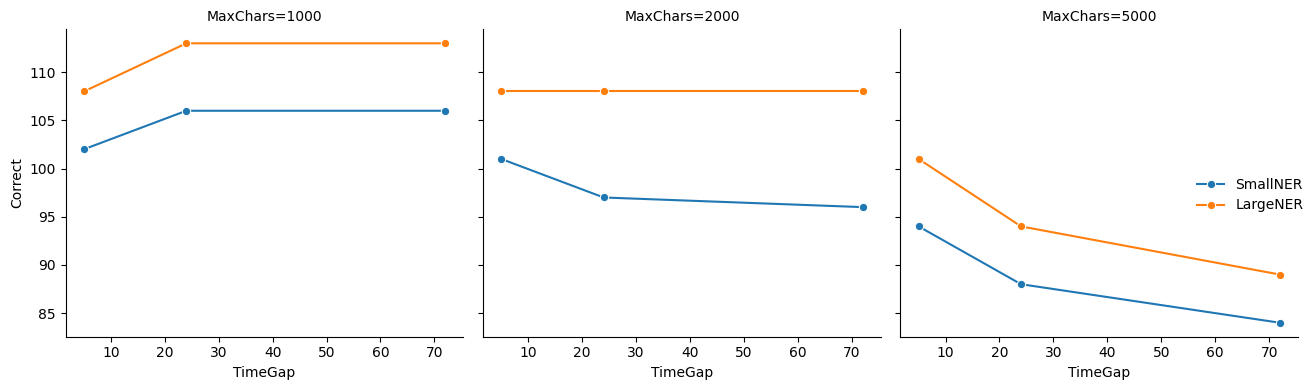

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Suppose df_results is the DataFrame with columns:
# ["Model", "TimeGap", "MaxChars", "Correct"]

# 1) Convert "Model" to a shorter label if desired:
df_plot = df_results.copy()
df_plot["ShortModel"] = df_plot["Model"].apply(lambda x: "SmallNER" if "dictabert-ner" in x and "large" not in x else "LargeNER")

# 2) We can create a facet grid: each MaxChars in columns, TimeGap on x-axis, lines for each model.
g = sns.FacetGrid(df_plot, col="MaxChars", height=4, sharey=True)
g.map_dataframe(
    sns.lineplot,
    x="TimeGap",
    y="Correct",
    hue="ShortModel",
    marker="o"
)
g.add_legend()
g.set_titles(col_template="MaxChars={col_name}")
plt.tight_layout()
plt.show()


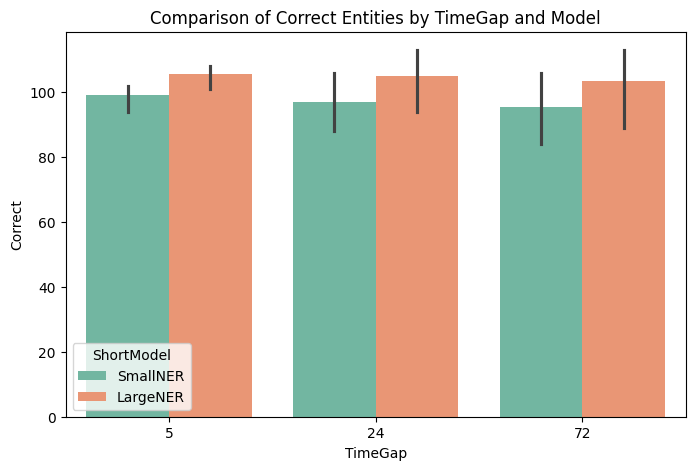

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_plot,
    x="TimeGap",
    y="Correct",
    hue="ShortModel",
    palette="Set2"
)
plt.title("Comparison of Correct Entities by TimeGap and Model")
plt.show()



=== Evaluation Results ===
Total Gold Entities: 136
Total Predicted Entities: 128
Correct: 113
Precision: 0.883
Recall: 0.831
F1: 0.856


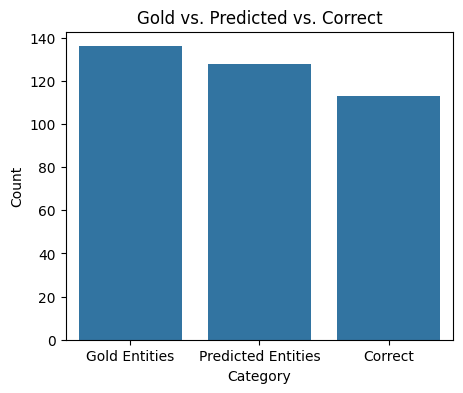

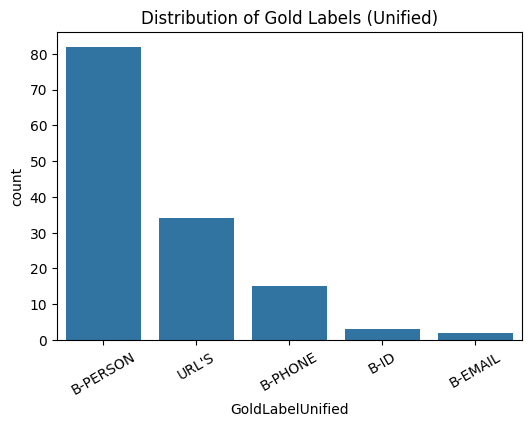

In [ ]:
######################################
# Merged code from earlier:
######################################

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

######################################
# Helper function: unify_label_for_graph
######################################
def unify_label_for_graph(lbl):
    """
    If label is in:
      [B-PERSON, BI-PERSON, B-PHONE, B-ID, B-EMAIL]
    keep it as is;
    otherwise call it 'URL'S'
    """
    if not isinstance(lbl, str):
        return "URL'S"  # if NaN or None
    keep_list = ["B-PERSON","BI-PERSON","B-PHONE","B-ID","B-EMAIL"]
    if lbl not in keep_list:
        return "URL'S"
    return lbl

######################################
# Main function: evaluate_merged_df
######################################
def evaluate_merged_df(df_merged):
    """
    df_merged includes:
      ID, EntityIndex, GoldToken, GoldLabel,
      PredToken, PredLabel, ...
    Returns a dict with precision, recall, f1, and draws both basic and extended graphs
    """

    # Filter out rows with neither GoldLabel nor PredLabel
    df_eval = df_merged.dropna(subset=["GoldLabel","PredLabel"], how="all").copy()

    # Count how many gold/pred entities exist
    df_eval["GoldExists"] = ~df_eval["GoldLabel"].isna()
    df_eval["PredExists"] = ~df_eval["PredLabel"].isna()

    total_gold = df_eval["GoldExists"].sum()    # how many rows with gold
    total_pred = df_eval["PredExists"].sum()    # how many rows with pred

    # "Correct" = (GoldToken == PredToken) only
    def is_correct(row):
        if row["GoldExists"] and row["PredExists"]:
            return (row["GoldToken"] == row["PredToken"])
        return False

    df_eval["IsCorrect"] = df_eval.apply(is_correct, axis=1)
    correct = df_eval["IsCorrect"].sum()

    precision = correct / total_pred if total_pred > 0 else 0
    recall = correct / total_gold if total_gold > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision+recall)>0 else 0

    print("\n=== Evaluation Results ===")
    print(f"Total Gold Entities: {int(total_gold)}")
    print(f"Total Predicted Entities: {int(total_pred)}")
    print(f"Correct: {int(correct)}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1: {f1:.3f}")

    # 1) Basic barplot: Gold vs. Pred vs. Correct
    counts = pd.DataFrame({
        "Category": ["Gold Entities", "Predicted Entities", "Correct"],
        "Count": [total_gold, total_pred, correct]
    })
    plt.figure(figsize=(5,4))
    sns.barplot(data=counts, x="Category", y="Count")
    plt.title("Gold vs. Predicted vs. Correct")
    plt.show()

    # 2) Distribution of Gold Labels, after unifying them
    df_gold_only = df_eval[df_eval["GoldExists"]].copy()
    df_gold_only["GoldLabelUnified"] = df_gold_only["GoldLabel"].apply(unify_label_for_graph)

    plt.figure(figsize=(6,4))
    sns.countplot(data=df_gold_only,
                  x="GoldLabelUnified",
                  order=df_gold_only["GoldLabelUnified"].value_counts().index)
    plt.title("Distribution of Gold Labels (Unified)")
    plt.xticks(rotation=30)
    plt.show()

    # Return metrics
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "correct": correct,
        "total_gold": total_gold,
        "total_pred": total_pred
    }

df_merged_all = pd.read_excel("df_merged_all.xlsx")
results = evaluate_merged_df(df_merged_all)


In [ ]:
print(df_correct)

      ID  EntityIndex     GoldToken   GoldLabel  \
0      1            1  972526344270     B-PHONE   
4      5            1          לניר    B-PERSON   
8      9            1          לניר    B-PERSON   
9     10            1           ניר    B-PERSON   
25    26            1     207209297        B-ID   
..   ...          ...           ...         ...   
671  662            1          רוקח    B-PERSON   
679  670            1  972508838661     B-PHONE   
685  676            1           URL  B-WHATSAPP   
703  693            1           ניר    B-PERSON   
720  710            1           ניר    B-PERSON   

                                               content  \
0                        ראית את המייל @972526344270 ?   
4                     נזכיר לניר שיש לנו עד סוף החודש?   
8                             אגב תגידו מה לענות לניר?   
9                  מצד אחד באמת רוצה לשתף פעולה עם ניר   
25                                           207209297   
..                                     